In [3]:
from datetime import datetime, timezone
from pydantic import BaseModel
import matplotlib.pyplot as plt
import numpy as np

class Candle(BaseModel):
    ts: datetime = None
    meta: str = None
    open: float = None
    high: float = None
    low: float = None
    close: float = None
    volume: float = None

In [4]:
import pymongo
import os
from dotenv import load_dotenv

load_dotenv()

client = pymongo.MongoClient(os.environ.get("MONGO_URL"))
database = client.get_database(os.environ.get("DATABASE"))
candles_collection = database.get_collection("MinuteCandles")
orders_collection = database.get_collection("orders")

In [5]:
def fetch_existing_orders(start_date: datetime):
    """
    This function is used to fetch all existing orders foranalysis purpose
    """
    query = [
        {
            '$match': {
                'order_execution_time': {
                    '$gt': start_date
                }
            }
        }, 
        {
            '$group': {
                '_id': '$order_id', 
                'count': {
                    '$sum': 1
                }, 
                'quantity': {
                    '$sum': '$quantity'
                }, 
                'order_execution_time': {
                    '$first': '$order_execution_time'
                }, 
                'price': {
                    '$first': '$price'
                }, 
                'trading_symbol': {
                    '$first': '$trading_symbol'
                }, 
                'trade_type': {
                    '$first': '$trade_type'
                }
            }
        }, {
            '$lookup': {
                'from': 'instruments', 
                'localField': 'trading_symbol', 
                'foreignField': 'trading_symbol', 
                'as': 'instrument'
            }
        }, {
            '$unwind': {
                'path': '$instrument', 
                'preserveNullAndEmptyArrays': False
            }
        }, {
            '$sort': {
                'order_execution_time': -1
            }
        }
    ]
    orders_list = list(orders_collection.aggregate(query))
    return orders_list

In [6]:
def project_profit(instrument_key: str, entry_time: datetime, stop_loss_percent: float, trailing_percent: float):
    """
    Projects profit/loss based on entry time and trailing stop loss

    The bot will execute sell order whenever the stoploss hits. If stoplos doesn't hit, it will sell at 3PM.

    Here stop loss is update every minute because we have minute interval of data.
    In real world it is suposed to be updated every consecutive api call.

    Args:
        - `instrument_key` (str) : ID of the premium 
        - `entry_time` (datetime) : Time when entered
        - `stop_loss_percent` (float) : % of trailing stop loss set for the premium
        - `trailing_percent` (float) : % of increase before stop loss is updated
    """
    entry_price: float = -1
    stop_loss: float = -1
    exit_price: float = -1
    trailing_target: float = -1
    trailing_variation: float = -1

    historical_data = list(candles_collection.find({
        "meta": instrument_key
    }))

        
    value_list = []
    if len(historical_data) == 0:
        return None, None
    for data in historical_data:
        candle: Candle = Candle(**data)
        
        # Entry 
        if(candle.ts > entry_time and entry_price == -1):
            entry_price = candle.open
            stop_loss = entry_price - entry_price*stop_loss_percent
            trailing_target = entry_price + entry_price*trailing_percent
            trailing_variation = entry_price*trailing_percent
        
        if entry_price != -1:
            value = {
                "stop_loss": stop_loss,
                "trailing_target": trailing_target,
                "premium": candle.low,
                "time": candle.ts
            }
            value_list.append(value)
            
            # Exit
            if (candle.low < stop_loss or (candle.ts == 15 and candle.ts == 10)):
                exit_price = candle.close
                break

            # Trailing Stoploss
            if (candle.high > trailing_target):
                stop_loss = stop_loss + trailing_variation
                trailing_target = trailing_target + trailing_variation
            

            
    
    profit = exit_price - entry_price

    result = {
        "EntryTime": entry_time,
        "ExitTime": candle.ts,
        "EntryPrice": entry_price,
        "ExitPrice": exit_price,
        "Profit": exit_price - entry_price,
        "Profit %":  (profit/entry_price)*100,
    }
    # print(result)
    return value_list, result

In [214]:
orders_list = fetch_existing_orders(start_date=datetime(2023, 11, 9, 0, 0, 0, tzinfo=timezone.utc))

stop_loss_percent_list = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
trailing_percent_list = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]


for order in orders_list:
    if order.get("trade_type") == "sell":
        continue
    # result_value_list = []
    max_profit = 0
    ideal = {}
    index = 0
    for stop_loss in stop_loss_percent_list:
        for trailing_percent in trailing_percent_list:
            if trailing_percent <= stop_loss:
                resultant = project_profit(
                    instrument_key=order.get("instrument").get("instrument_key"),
                    entry_time=order.get("order_execution_time"),
                    stop_loss_percent=stop_loss/100,
                    trailing_percent=trailing_percent/100
                )
                value_list = resultant[0]
                current_result = resultant[1]

                if not value_list or not current_result:
                    break

                # result_value_list.append({
                #     "stop_loss": stop_loss,
                #     "trailing_percent": trailing_percent,
                #     "profit": ((value_list[-1].get("premium") - value_list[0].get("premium"))/value_list[0].get("premium"))*100,
                #     "value_list": value_list
                # })
                index = index + 1
                if current_result.get("Profit %") > max_profit:
                    max_profit = current_result.get("Profit %")
                    ideal = current_result
                    ideal["stoploss"] = stop_loss
                    ideal["trailing_percent"] = trailing_percent
                    ideal["index"] = index

    buy_details = {
       "time": order.get("order_execution_time") ,
       "price": order.get("price"),
       "trading_symbol": order.get("trading_symbol"),
       "instrument_key": order.get("instrument").get("instrument_key"),
    }
    print(buy_details)
    if ideal != {}:
        sell_details = {
            "time": ideal.get("ExitTime") ,
            "price": ideal.get("ExitPrice"),
            "Profit %": ideal.get('Profit %'),
            "Stoploss %": ideal.get("stoploss"),
            "Trailing %": ideal.get("trailing_percent"),
        }
        print(sell_details)
    else:
        print("There was never a trade here")
    print("---------------------")

{'time': datetime.datetime(2023, 11, 10, 11, 14, 18), 'price': 162.5, 'trading_symbol': 'BANKNIFTY23N1543600PE', 'instrument_key': 'NSE_FO|41344'}
{'time': datetime.datetime(2023, 11, 10, 11, 39), 'price': 166.1, 'Profit %': 1.0955569080949377, 'Stoploss %': 7, 'Trailing %': 3}
---------------------
{'time': datetime.datetime(2023, 11, 9, 14, 34, 19), 'price': 10.65, 'trading_symbol': 'NIFTY23N0919400CE', 'instrument_key': 'NSE_FO|42690'}
There was never a trade here
---------------------
{'time': datetime.datetime(2023, 11, 9, 10, 43, 35), 'price': 43.15, 'trading_symbol': 'NIFTY23N0919450PE', 'instrument_key': 'NSE_FO|42703'}
There was never a trade here
---------------------
{'time': datetime.datetime(2023, 11, 9, 10, 27, 52), 'price': 31.55, 'trading_symbol': 'NIFTY23N0919400CE', 'instrument_key': 'NSE_FO|42690'}
There was never a trade here
---------------------
{'time': datetime.datetime(2023, 11, 9, 10, 27, 29), 'price': 28.15, 'trading_symbol': 'NIFTY23N0919400CE', 'instrument_

/Users/reverie4/Documents/Projects/money-bhai/src/scrapper/candles.py:153: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(res) is not 0:
/Users/reverie4/Documents/Projects/money-bhai/src/scrapper/candles.py:153: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(res) is not 0:


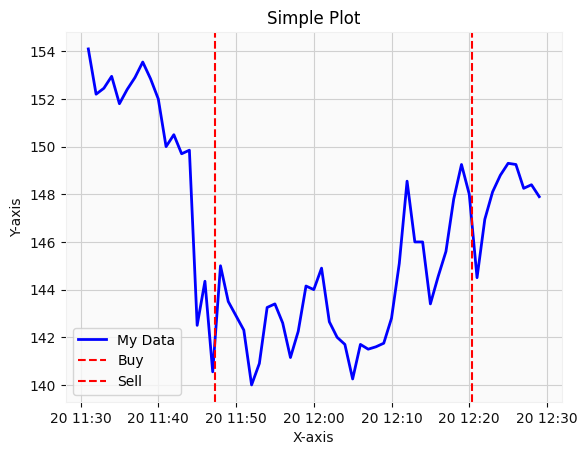

In [215]:
# Plot graph of premium on particular day

premium = "NSE_FO|50112"

query = [
    {
        '$match': {
            'meta': premium, 
            'ts': {
                '$gt': datetime(2023, 10, 20, 11, 30, 0, tzinfo=timezone.utc), 
                '$lt': datetime(2023, 10, 20, 12, 30, 0, tzinfo=timezone.utc)
            }
        }
    }
]
data_list = list(candles_collection.aggregate(query))

x = [candle.get("ts") for candle in data_list]
y = [candle.get("open") for candle in data_list]

plt.plot(x, y, label='My Data', color='blue', linewidth=2)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.axvline(x=datetime(2023, 10, 20, 11, 47, 18), color='red', linestyle='--', label='Buy')
plt.axvline(x=datetime(2023, 10, 20, 12, 20, 18), color='red', linestyle='--', label='Sell')
plt.title('Simple Plot')
plt.legend()
plt.show()

5EMA Testing

In [7]:
def fetch_candle_data_instrument(instrument_key: str, start_date: datetime, bucket: int):
    historical_data = list(candles_collection.aggregate([
        {
            '$match': {
                'ts': {
                    '$gt':start_date
                }, 
                'meta': instrument_key
            }
        }, {
            '$addFields': {
                'roundedTime': {
                    '$dateTrunc': {
                        'date': '$ts', 
                        'unit': 'minute', 
                        'binSize': bucket
                    }
                }
            }
        }, {
            '$group': {
                '_id': '$roundedTime', 
                'volume': {
                    '$sum': '$volume'
                }, 
                'open': {
                    '$first': '$open'
                }, 
                'close': {
                    '$last': '$close'
                }, 
                'high': {
                    '$max': '$high'
                }, 
                'low': {
                    '$min': '$low'
                }, 
                'candles': {
                    '$push': '$$ROOT'
                }, 
                'ts': {
                    '$first': '$roundedTime'
                }
            }
        }, {
            '$sort': {
                'ts': 1
            }
        }
    ]))

    candles_list: list[Candle] = []

    for data in historical_data:
        candle: Candle = Candle(**data)
        candles_list.append(candle)
    
    return candles_list
        

In [8]:

candles_list: list[Candle] = fetch_candle_data_instrument(instrument_key="NSE_INDEX|Nifty 50", start_date=datetime(year=2023, month=11, day=10), bucket=5)

In [9]:
import pandas as pd

def calculate_ema(data, alpha):
    """
    Calculate Exponential Moving Average (EMA) using pandas.

    Parameters:
    - data: List or pandas Series representing the time series data.
    - alpha: Smoothing factor (usually between 0 and 1).

    Returns:
    - ema: Pandas Series containing the EMA values.
    """
    ema = pd.Series(data).ewm(alpha=alpha, adjust=False).mean()
    return ema

In [10]:
def fin_5_EMA_entry_list(ema_list: list):
    alert_candle: Candle = None
    entry_candle_ema_list = []
    for index, ema in enumerate(ema_list):
        entry_point = np.nan
        if ema < candles_list[index].low:
            alert_candle = candles_list[index]
        else:
            if alert_candle:
                entry_point = ema
            alert_candle = None
        entry_candle_ema_list.append(entry_point)
    return entry_candle_ema_list

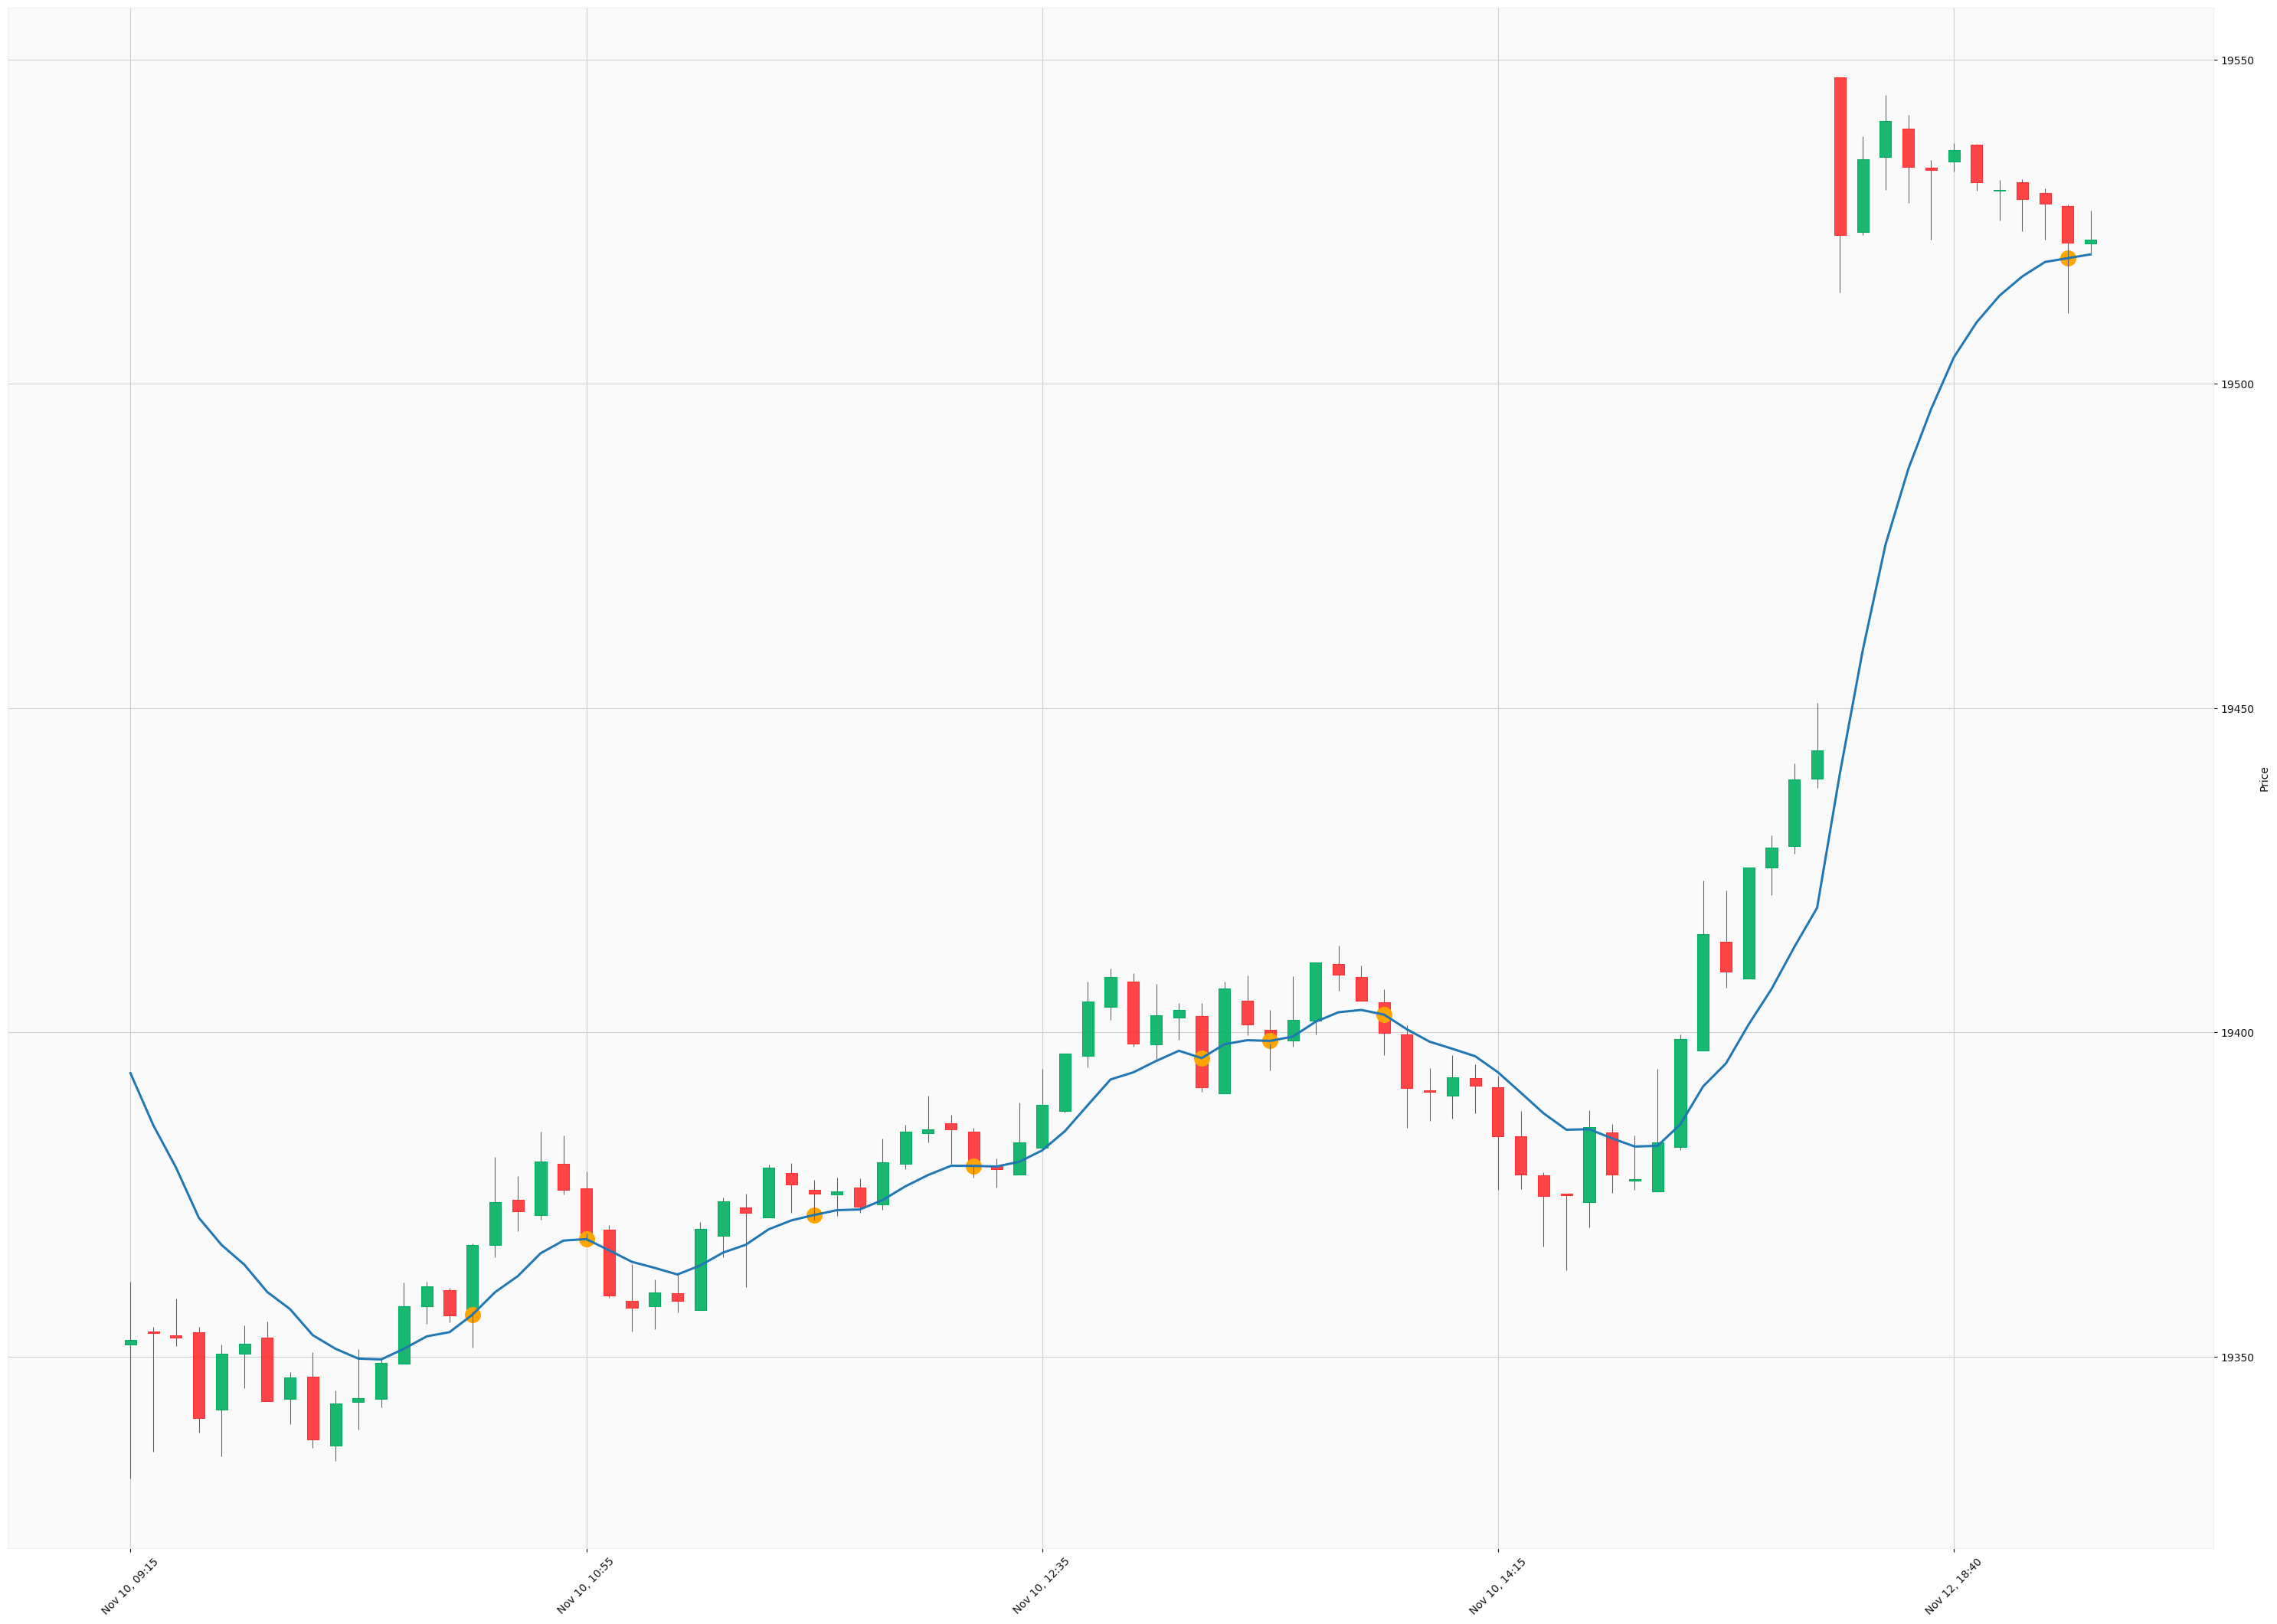

TypeError: cannot unpack non-iterable NoneType object

In [220]:


from datetime import datetime, timedelta
import mplfinance as mpf
import pandas as pd 


time_list = []
price_list = []
for candle in candles_list:
    price_list.append(candle.low)
    time_list.append(candle.ts)

# Calculate EMA
closing_list = [19404]
for candle in candles_list:
    closing_list.append(candle.close)

ema_result = calculate_ema(closing_list, 0.2)

# Find entry points
ema_list = ema_result[1:]
entry_candle_ema_list = fin_5_EMA_entry_list(ema_list=ema_list)

# Create DataFrame 
plt_data = {
    'Date': [pd.to_datetime(candle.ts) for candle in candles_list], 
    'Open': [candle.open for candle in candles_list],
    'High': [candle.high for candle in candles_list],
    'Low': [candle.low for candle in candles_list],
    'Close': [candle.close for candle in candles_list],
    'Volume': [candle.volume for candle in candles_list],
} 
df = pd.DataFrame(plt_data) 

# Configure and display plot
df = df.set_index(pd.DatetimeIndex(df['Date']))
entry_sell_plot = mpf.make_addplot(entry_candle_ema_list, type='scatter', marker='o', color='orange',markersize=200)
ema_plot = mpf.make_addplot(ema_list)
fig, axlist = mpf.plot(df, type='candle', style='yahoo', ylabel='Price', figscale=5, addplot=[entry_sell_plot, ema_plot])

# axlist[0].xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
# Create the line graph
# plt.plot(time_list, price_list, label="Price")

# # Adding labels and a title
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('Line Graph Example')

# Display the plot
plt.show()


In [ ]:
entry_counter = 0
for data in alert_candle_ema:
    if data is not np.nan:
        entry_counter += 1
entry_counter
        

1

5EMA Back Testing

In [103]:

minute_candel_list: list[Candle] = fetch_candle_data_instrument(instrument_key="NSE_INDEX|Nifty 50", start_date=datetime(year=2023, month=11, day=1), bucket=1)
# Calculate EMA
five_minute_candel_list: list[Candle] = fetch_candle_data_instrument(instrument_key="NSE_INDEX|Nifty 50", start_date=datetime(year=2023, month=11, day=1), bucket=5)
closing_list = [19086] # 31st oct closing
# closing_list = [19086]
# closing_list = [19086]
for candle in five_minute_candel_list:
    closing_list.append(candle.close)

ema_list = calculate_ema(closing_list, 0.2)


In [118]:
trailing_value = 5
def project_ema_profit(alert_candle: Candle):
    candle: Candle = None
    entry_candle: Candle = None
    ema_list_counter: int = 1
    for candle in minute_candel_list:
        if candle.ts.minute % 5 == 0:
            ema = ema_list[ema_list_counter]
            ema_list_counter = ema_list_counter + 1
            
        if candle.ts > alert_candle.ts:
            if candle.low <= ema and entry_candle == None:
                list_of_ema = ema_list[ema_list_counter-10:ema_list_counter]
                # if np.var(list_of_ema) < 3:
                #     continue
                
                entry_candle = candle
                stop_loss = alert_candle.high
                trailing_target = candle.low - trailing_value
                print("Entered Here", candle.ts, stop_loss, trailing_target, np.var(list_of_ema))
                continue
    
            if entry_candle:
                if stop_loss <= candle.high:
                    # print("Exit", "Stoploss hit", candle.ts)
                    profit = entry_candle.low - stop_loss
                    print(profit)
                    break
                elif trailing_target > candle.low:
                    # print("trail target")
                    stop_loss = stop_loss - trailing_value
                    trailing_target = trailing_target - trailing_value

                if candle.ts.hour == 15 and candle.ts.minute == 15:
                    print("Exit", "Intraday auto square off")
                    break
    
    return({
        "entered_at": entry_candle.ts,
        "exit_at": candle.ts,
        "profit": entry_candle.low - stop_loss,
        "stop_loss": stop_loss,
        "trailing_target": trailing_target
    })

In [119]:

trailing_target = 0
alert_candle: Candle = None
entry_candle: Candle = None
exit_candle: Candle = None
candle: Candle = None
ema_list_counter = 1
result_list = []

for candle in five_minute_candel_list:
    ema = ema_list[ema_list_counter]
    ema_list_counter = ema_list_counter + 1

    if candle.low > ema:
        alert_candle = candle
    else:        
        if alert_candle:
            result = project_ema_profit(alert_candle=alert_candle)
            result_list.append(result)
            alert_candle = None

profit_total = 0
for res in result_list:
    profit_total = profit_total + res.get("profit")
    print("profit_total", profit_total)
    

        

Entered Here 2023-11-01 12:30:00 19065.45 19041.5 6.551313996373112
36.04999999999927
Entered Here 2023-11-01 13:52:00 19036.0 19016.45 35.08865404914769
0.4500000000007276
Entered Here 2023-11-02 10:11:00 19147.8 19125.65 434.7186583189252
2.850000000002183
Entered Here 2023-11-02 11:20:00 19130.0 19113.7 4.613574223191041
33.70000000000073
Entered Here 2023-11-02 12:30:00 19097.4 19082.55 36.4765413964099
-4.850000000002183
Entered Here 2023-11-02 13:24:00 19114.65 19089.85 26.022986832479887
-19.80000000000291
Entered Here 2023-11-02 14:07:00 19136.05 19113.35 41.921473922378496
-17.700000000000728
Entered Here 2023-11-02 14:22:00 19140.7 19114.15 45.15112413122476
-11.549999999999272
Entered Here 2023-11-02 15:12:00 19138.0 19117.65 7.811455107515454
Exit Intraday auto square off
Entered Here 2023-11-03 10:27:00 19270.9 19249.7 150.8681076936191
-16.200000000000728
Entered Here 2023-11-03 10:56:00 19268.05 19254.05 8.494948038775915
-9.0
Entered Here 2023-11-03 11:18:00 19273.15 19